This script was based on the article below:
https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26

I should add a reference for this

"It calculates the correlation/strength-of-association of features in the data-set with both categorical and continuous features using: Pearson’s R for continuous-continuous cases, Correlation Ratio for categorical-continuous cases, Cramer’s V or Theil’s U for categorical-categorical cases."

## Do general imports

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from dython.nominal import associations
from dython.nominal import correlation_ratio
from dython.data_utils import split_hist


pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 14})


## Load Datasets

In [3]:
issues_df = pd.read_csv('./temp_data/issues.csv', index_col=["id"])
issues_df['issue_created'] = pd.to_datetime(issues_df['issue_created'])
print(F'Total records in dataset %i' % len(issues_df))
issues_df.head(1)

Total records in dataset 66691


,started,ended,issue_num,issue_proj,issue_reporter,issue_assignee,issue_contr_count,issue_type,issue_priority,issue_created,issue_resolution_date,issue_resolution,issue_status,issue_comments_count,last_change_date,wf_in_review,wfe_in_review,wf_deployment,wfe_deployment,wf_resolved,wfe_resolved,wf_open,wfe_open,wf_monitoring,wfe_monitoring,wf_done,wfe_done,wf_pending_customer_approval,wfe_pending_customer_approval,wf_rejected,wfe_rejected,wf_testing_monitoring,wfe_testing_monitoring,wf_in_progress,wfe_in_progress,wf_reopened,wfe_reopened,wf_to_do,wfe_to_do,wf_validation,wfe_validation,wf_resolved_under_monitoring,wfe_resolved_under_monitoring,wf_closed,wfe_closed,wf_waiting,wfe_waiting,wf_cancelled,wfe_cancelled,wf_under_review,wfe_under_review,wf_approved,wfe_approved,wf_pending_deployment,wfe_pending_deployment,wf_total_time,processing_steps
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11887.0,2016-01-06 08:23:43+00:00,2016-01-06 08:56:55+00:00,186.0,SCAB,u390,NaN,1.0,Ticket,Medium,2016-01-06 08:23:43+00:00,2016-01-06 08:56:55+00:00,Done,done,1,2016-04-02 12:20:21+00:00,NaN,0,NaN,0,NaN,0,29.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,1963.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,1992.0,2


In [4]:
# types = ['Ticket','Service','Deployment','HD Service','Project']
types = ['Ticket','Deployment','HD Service']

issues_df = issues_df[(issues_df['issue_proj'].str.match('\w{2}\d{2}\w{1,}'))
                      & (issues_df['issue_type'].isin(types))
                      & (issues_df['issue_created'] >= '2022-01-01')
                      & (issues_df['issue_created'] <= '2022-12-31')
                      & pd.notna(issues_df['issue_resolution_date'])]
                      # & (issues_df['issue_priority'] == 'High')]
print(F'Total records after filter %i' % len(issues_df))

issues_df.head(1)

Total records after filter 5451


,started,ended,issue_num,issue_proj,issue_reporter,issue_assignee,issue_contr_count,issue_type,issue_priority,issue_created,issue_resolution_date,issue_resolution,issue_status,issue_comments_count,last_change_date,wf_in_review,wfe_in_review,wf_deployment,wfe_deployment,wf_resolved,wfe_resolved,wf_open,wfe_open,wf_monitoring,wfe_monitoring,wf_done,wfe_done,wf_pending_customer_approval,wfe_pending_customer_approval,wf_rejected,wfe_rejected,wf_testing_monitoring,wfe_testing_monitoring,wf_in_progress,wfe_in_progress,wf_reopened,wfe_reopened,wf_to_do,wfe_to_do,wf_validation,wfe_validation,wf_resolved_under_monitoring,wfe_resolved_under_monitoring,wf_closed,wfe_closed,wf_waiting,wfe_waiting,wf_cancelled,wfe_cancelled,wf_under_review,wfe_under_review,wf_approved,wfe_approved,wf_pending_deployment,wfe_pending_deployment,wf_total_time,processing_steps
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1006845.0,2022-06-05 07:56:43+00:00,2022-06-29 07:17:20+00:00,3448.0,QA00QIB,qa.qib.03,u895,1.0,HD Service,Medium,2022-06-05 07:56:43+00:00,2022-06-29 07:17:15+00:00,Done,closed,8,2022-06-29 07:17:20+00:00,NaN,0,NaN,0,NaN,0,1460.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,2069777.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,2071237.0,2


In [5]:
included = ['issue_comments_count','issue_contr_count','processing_steps','wf_total_time','issue_priority']

df = issues_df.drop(columns=[c for c in issues_df.columns if not c.startswith('wf_') and c not in included])
for i,c in enumerate(df.columns):
    if df.dtypes[i] == object:
        continue
    df.loc[pd.isna(df[c]),c] = 0
    df[c] = (df[c]-df[c].mean()) / df[c].std()
    df.rename(columns={c:c.replace('wf_','').replace('_',' ')},inplace=True)

a_results = associations(df,compute_only=True)


corr = a_results['corr']

<Axes: >

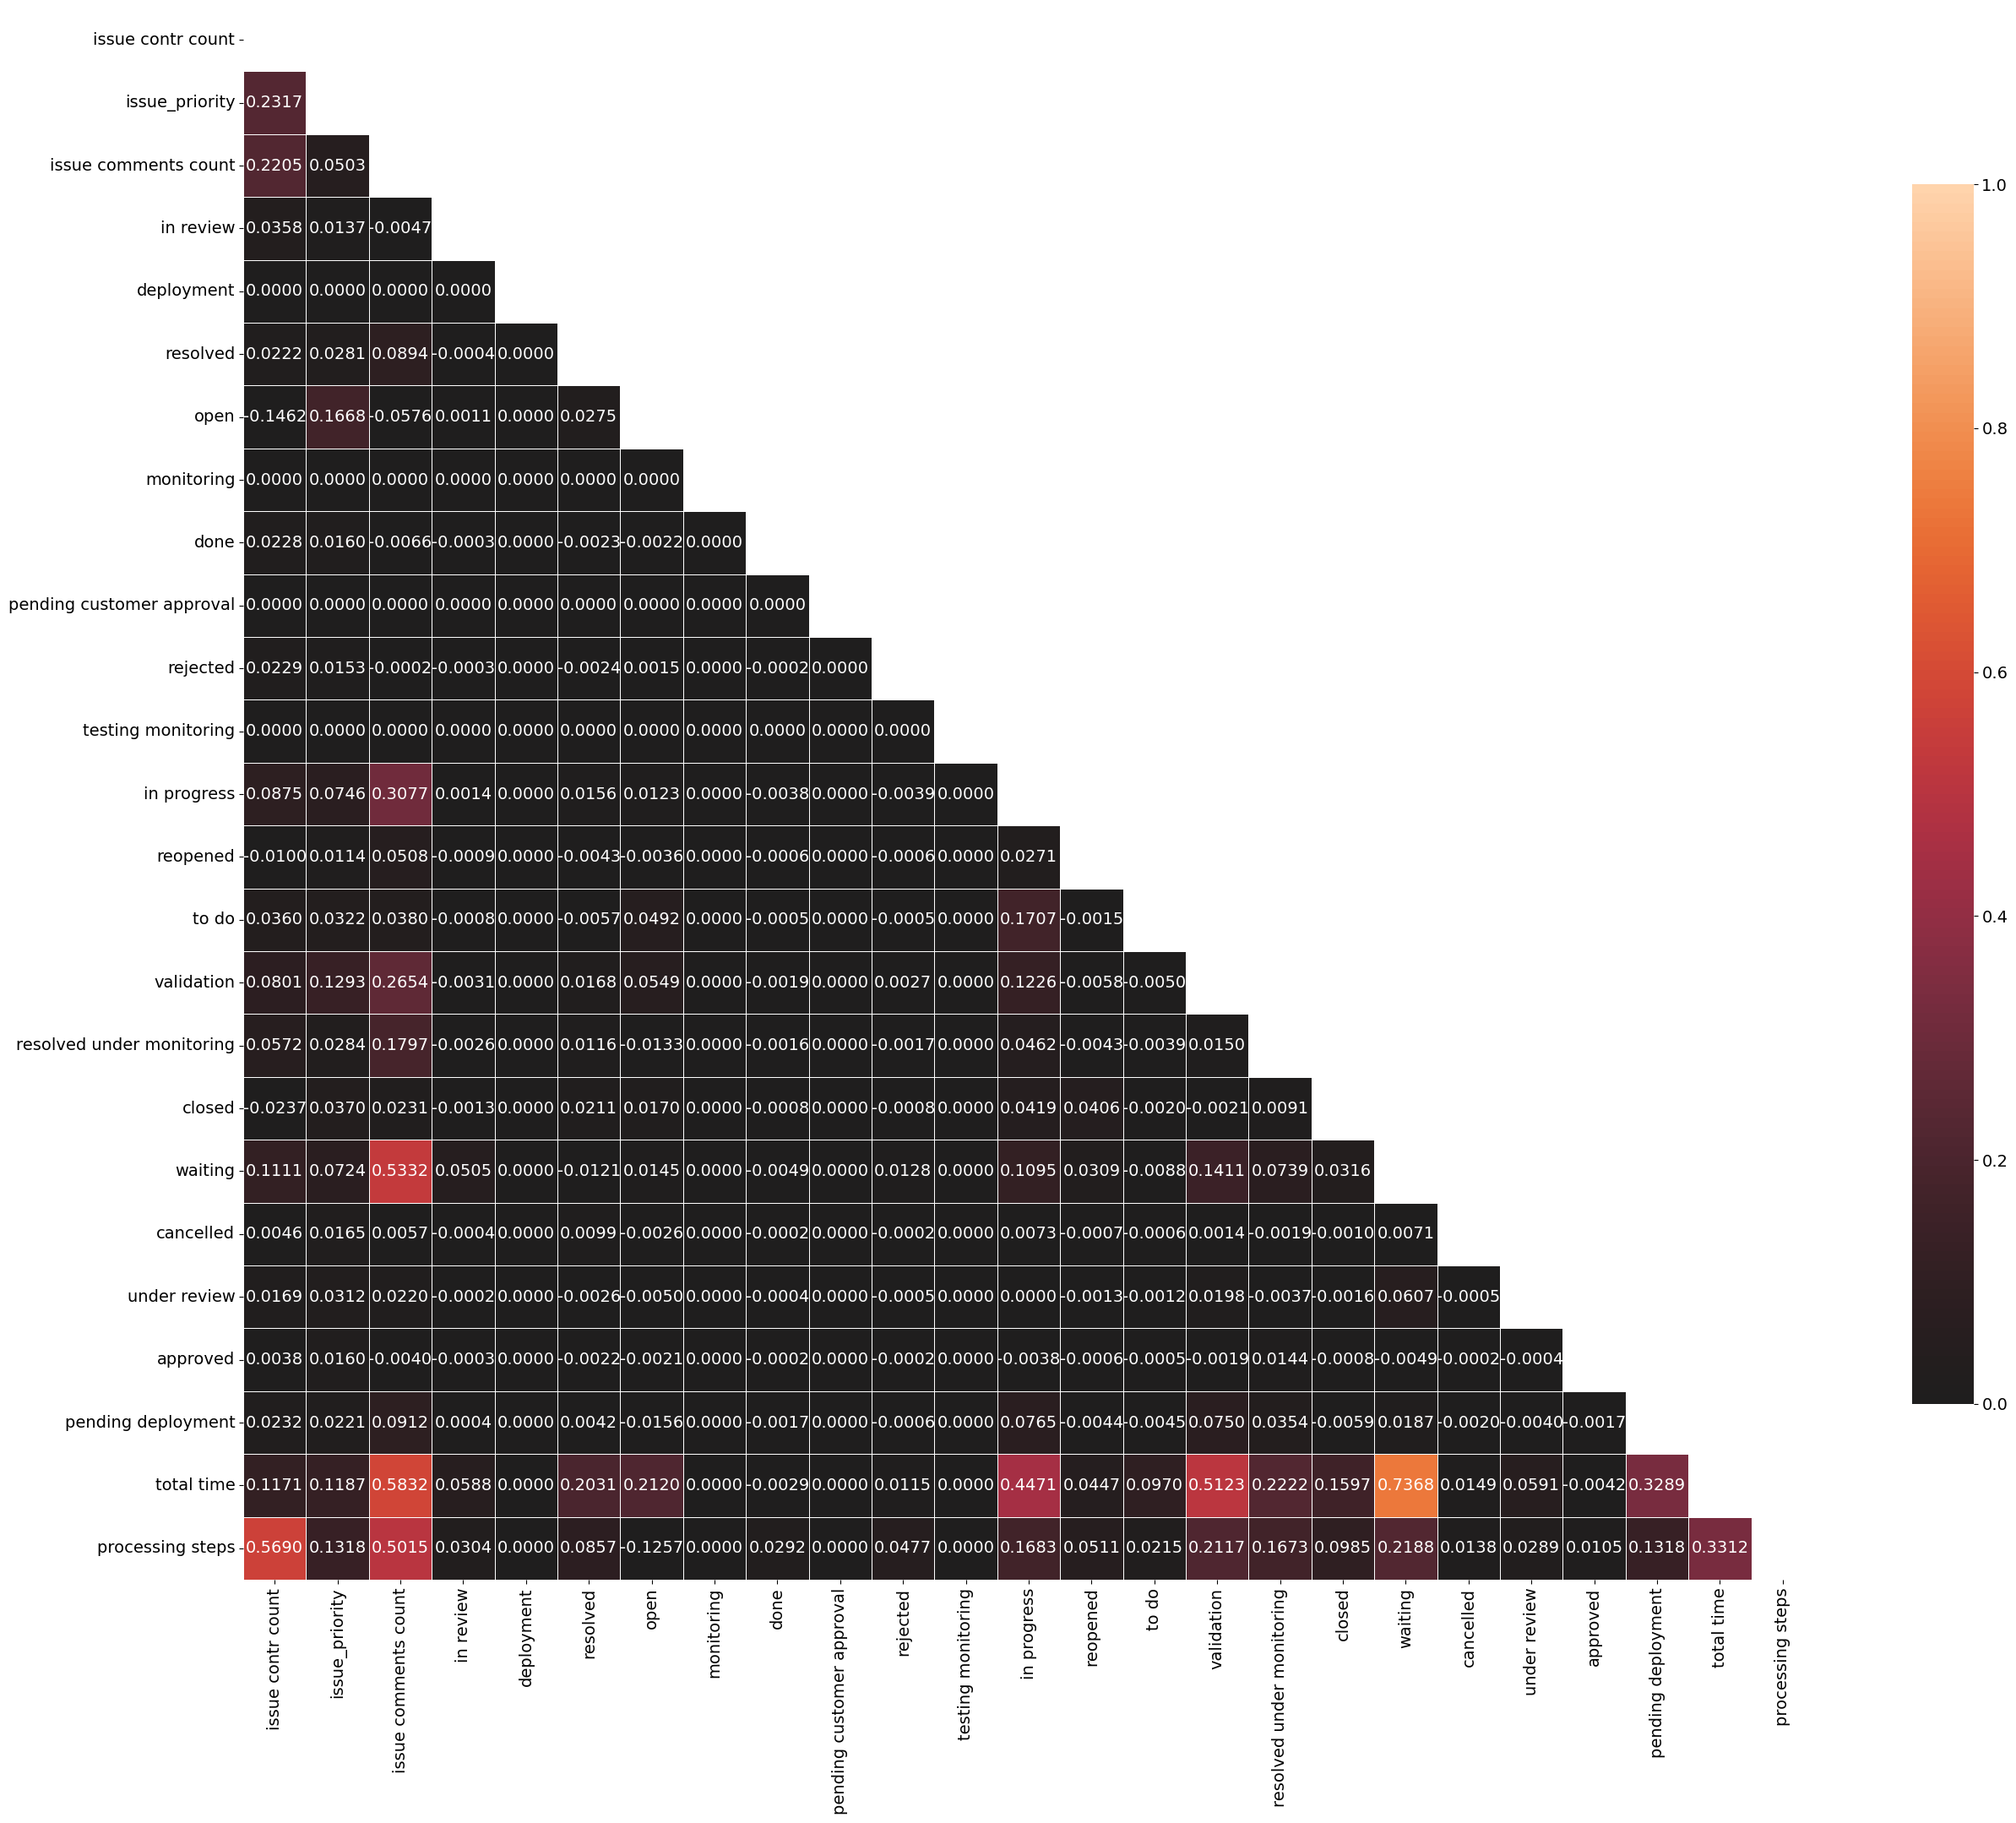

In [6]:
fig = plt.figure(figsize=(30, 25))
ax = fig.add_subplot(111)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect rati
sns.heatmap(corr,mask=mask, vmax=1,vmin=0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75}, ax = ax,annot=True,fmt=".4f",)

In [7]:
segnificant = ['total time','issue contr count','issue comments count','processing steps','in progress','validation','waiting','pending deployment']
corr = corr.loc[segnificant,segnificant]
renames = {'issue contr count':'contributors','issue comments count':'comments count'}
corr.rename(columns=renames,index=renames,inplace=True)

<Axes: >

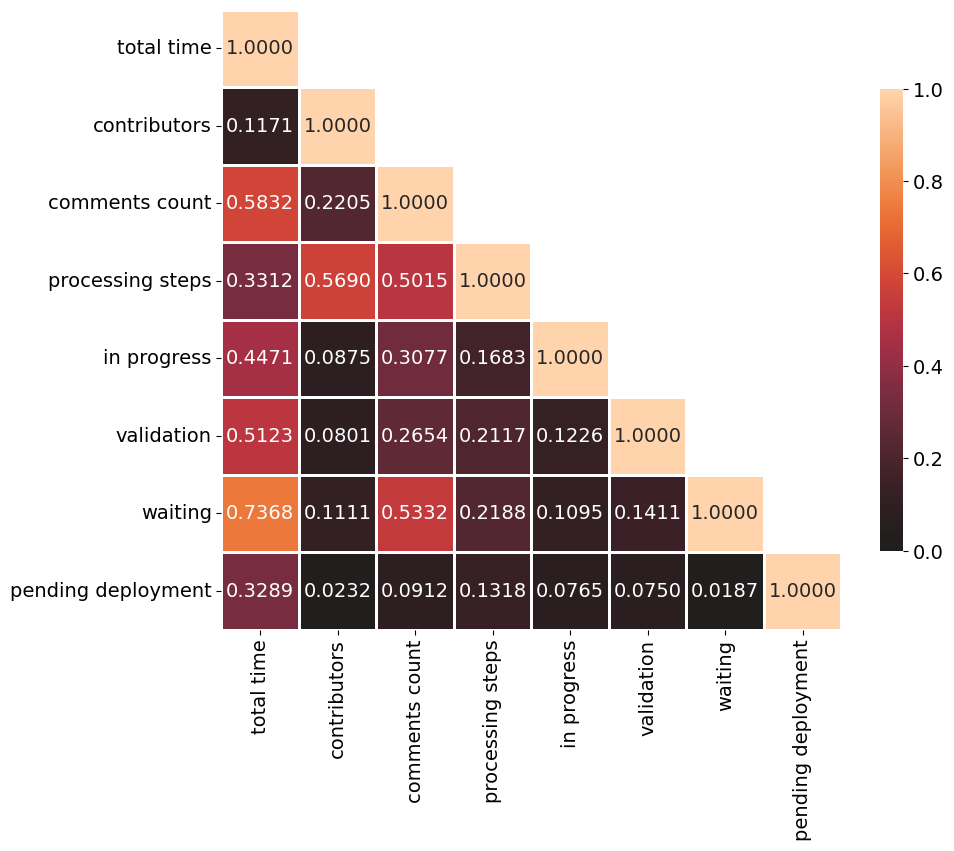

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

for i in range(len(mask)):
    mask[i][i] = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect rati
sns.heatmap(corr,mask=mask, vmax=1,vmin=0, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .6}, ax = ax,annot=True,fmt=".4f",)

### Conclusions
* It was found there is a positive correlation between workflow total time and how much time an issue spent in waiting, validation, and in progress (ordered from hightest to lowest correlation)
* Also, a positive correlation exists between workflow total time and comments count, it is not very high.

In [9]:
corr['total time'].sort_values(ascending=False)

total time            1.000000
waiting               0.736762
comments count        0.583188
validation            0.512322
in progress           0.447106
processing steps      0.331207
pending deployment    0.328868
contributors          0.117060
Name: total time, dtype: float64

Text(0, 0.5, 'In Progress')

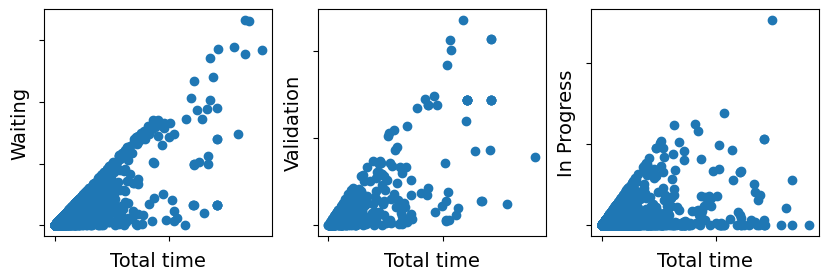

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(331)
ax.scatter(x=issues_df['wf_total_time'],y=issues_df['wf_waiting'])
ax.set_xlabel('Total time')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylabel('Waiting')

ax = fig.add_subplot(332)
ax.scatter(x=issues_df['wf_total_time'],y=issues_df['wf_validation'])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('Total time')
ax.set_ylabel('Validation')

ax = fig.add_subplot(333)
ax.scatter(x=issues_df['wf_total_time'],y=issues_df['wf_in_progress'])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('Total time')
ax.set_ylabel('In Progress')

# ax = fig.add_subplot(334)
# ax.scatter(x=issues_df['wf_total_time'],y=issues_df['processing_steps'])
# ax.set_xlabel('Total time')
# ax.set_ylabel('Processing Steps')

# ax = fig.add_subplot(335)
# ax.scatter(x=issues_df['wf_total_time'],y=issues_df['issue_comments_count'])
# ax.set_xlabel('Total time')
# ax.set_ylabel('Comments Count')